# 03. entrega final

en el siguiente notebook se puede observar la exploración inicial de los datos
[exploración](https://colab.research.google.com/drive/1Ta6oCFoSaoPLMxDyKNP12VUrhHDyCL5e?usp=sharing)


## Descargar datos desde kagle

- crear el archivo `kaggle.json` en kaggle (in kaggle $\to$ perfil $\to$ ajustes $\to$ crear nuevo token)
- subirlo en el almacenamiento de este notebook
- ejecutar la siguiente celda

In [44]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242
from google.colab import drive
drive.mount('/content/drive')
!unzip udea*.zip > /dev/null

udea-ai4eng-20242.zip: Skipping, found more recently modified local copy (use --force to force download)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


## Librerias usadas


In [2]:
#Librerias para el manejo de grandes volumenes de datos
import pandas as pd
import numpy as np

#Librerias usadas para el preprocesado de los datos
import unicodedata
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

#Librerias usadas para crear el modelo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

#librerias usadas para evaluar el modelo
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
# Cargar los datos de entrenamiento y prueba

trainKaggle = pd.read_csv("train.csv")
testKaggle = pd.read_csv("test.csv")

# Preprocesado

## Normalizacion de strings
Se definen dos métodos auxiliares para normalizar cadenas de texto, esto es, quitarles tildes, dejar todo en minusculas, quitar espacios al inicio y final. Esto con el fin de evitar tratar como diferente información que es igual pero que tiene una codificación diferente.

In [4]:
# Función de normalización de texto
# Esta función normaliza las cadenas de texto eliminando acentos y convirtiendo a minúsculas
def normalize_string(s):
    return (
        unicodedata.normalize('NFKD', s)
        .encode('ascii', errors='ignore')
        .decode('utf-8')
        .lower()
        .strip()
        .replace('  ', ' ')
    )
 # Función para extraer la primera palabra de un texto y eliminar caracteres específicos

def extraer_primera_palabra(texto):
    palabra = texto.replace('3','')
    palabra = palabra.split()[0]
    palabra= palabra.replace('-','')
    return palabra

## Mapeos
Se definen los diccionarios para mapear las variables categoricas a numericas. El diccionario mapeo_region se hace con el fin de evitar sobreajuste y aumentar la representatividad en cantidad de datos de departamentos que por si solos tienen pocos datos

In [22]:
# Diccionarios de mapeo
# Estos diccionarios permiten convertir categorías de texto en valores numéricos para el modelo
mapeo_rendimiento = {
    'bajo': 1,
    'medio-bajo': 2,
    'medio-alto': 3,
    'alto': 4
  }
map_matricula ={
    'Entre 5.5 millones y menos de 7 millones': 6,
    'Entre 2.5 millones y menos de 4 millones': 4,
    'Entre 4 millones y menos de 5.5 millones': 5,
    'Más de 7 millones': 7,
    'Entre 1 millón y menos de 2.5 millones': 3,
    'Entre 500 mil y menos de 1 millón': 2,
    'Menos de 500 mil': 1

  }
mapeo_horas = {
    '0': 0,
    'Menos de 10 horas': 1,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 3,
    'Más de 30 horas': 4
  }
mapeo_estracto = {
    'Estrato 3':3,
    'Estrato 4':4,
    'Estrato 5':5,
    'Estrato 2':2,
    'Estrato 1':1,
    'Estrato 6':6,
    'Sin Estrato':0
  }

mapeo_region = {
     'BOGOTÁ': 'BOGOTÁ',
    'ATLANTICO': 'Caribe',
    'SANTANDER': 'Andina',
    'ANTIOQUIA': 'ANTIOQUIA',
    'HUILA': 'Andina',
    'SUCRE': 'Caribe',
    'CAQUETA': 'otra',
    'CUNDINAMARCA': 'Andina',
    'BOLIVAR': 'Caribe',
    'TOLIMA': 'Andina',
    'VALLE': 'Andina',
    'QUINDIO': 'Andina',
    'RISARALDA': 'Andina',
    'CORDOBA': 'Caribe',
    'META': 'otra',
    'LA GUAJIRA': 'Caribe',
    'BOYACA': 'Andina',
    'NARIÑO': 'Andina',
    'CAUCA': 'Andina',
    'NORTE SANTANDER': 'Andina',
    'CESAR': 'Caribe',
    'PUTUMAYO': 'otra',
    'CALDAS': 'Andina',
    'MAGDALENA': 'Caribe',
    'CHOCO': 'otra',
    'CASANARE': 'otra',
    'ARAUCA': 'otra',
    'GUAVIARE': 'otra',
    'AMAZONAS': 'otra',
    'VAUPES': 'otra',
    'SAN ANDRES': 'otra',
    'VICHADA': 'otra'
  }


## Preprocesado
En el siguiente metodo se usan los diccionarios de la celda anterior, se hace one hot enconding a variables de la educación de padres. Se imputan datos con la moda o con KNNImputer y se retorna un nuevo dataframe

In [49]:
# Función de preprocesamiento de datos
def preprocess(dataframe):
  # Copia el dataframe para preservar los datos originales
  train = dataframe.copy()

  target = 'RENDIMIENTO_GLOBAL'
  # Mapear la variable objetivo si existe en los datos
  if(target in train):
    train[target] = train[target].map(mapeo_rendimiento)

  # Normalización del nombre del programa académico
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(normalize_string)
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(extraer_primera_palabra)

  # Agrupar los 15 programas más comunes, el resto se asigna como 'otra'
  frecuencia = train['ESTU_PRGM_ACADEMICO'].value_counts()
  top_10 = frecuencia.nlargest(15).index
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(lambda x: x if x in top_10 else 'otra')

  # Aplicar mapeo a varias columnas
  train['ESTU_PRGM_DEPARTAMENTO'] = train['ESTU_PRGM_DEPARTAMENTO'].map(mapeo_region)
  train['FAMI_ESTRATOVIVIENDA'] = train['FAMI_ESTRATOVIVIENDA'].map(mapeo_estracto)
  train['ESTU_HORASSEMANATRABAJA'] = train['ESTU_HORASSEMANATRABAJA'].map(mapeo_horas)
  train["ESTU_VALORMATRICULAUNIVERSIDAD"] = train["ESTU_VALORMATRICULAUNIVERSIDAD"].map(map_matricula)
  frecuencia = train['ESTU_PRGM_DEPARTAMENTO'].value_counts()

  # Imputación de valores faltantes en educación de padres usando la moda
  modaPadre = train['FAMI_EDUCACIONMADRE'].mode()[0]
  modaMadre = train['FAMI_EDUCACIONPADRE'].mode()[0]
  train['FAMI_EDUCACIONMADRE'].fillna(modaMadre, inplace=True)
  train['FAMI_EDUCACIONPADRE'].fillna(modaPadre, inplace=True)

  # One-hot encoding en educación de padres y conexión a internet
  one_hot_encoded_p = pd.get_dummies(train['FAMI_EDUCACIONPADRE'], prefix='FAMI_EDUCACIONPADRE')
  train = pd.concat([train, one_hot_encoded_p], axis=1)
  train.drop('FAMI_EDUCACIONPADRE', axis=1, inplace=True)
  one_hot_encoded_m = pd.get_dummies(train['FAMI_EDUCACIONMADRE'], prefix='FAMI_EDUCACIONMADRE')
  train = pd.concat([train, one_hot_encoded_m], axis=1)
  train.drop('FAMI_EDUCACIONMADRE', axis=1, inplace=True)

  #imputar a fami tiene internet
  modaInternet = train['FAMI_TIENEINTERNET'].mode()[0]
  train['FAMI_TIENEINTERNET'].fillna(modaInternet, inplace=True)

  #one hot a fami tiene internet
  one_hot_encoded_p = pd.get_dummies(train['FAMI_TIENEINTERNET'], prefix='FAMI_TIENEINTERNET')
  train = pd.concat([train, one_hot_encoded_p], axis=1)
  train.drop('FAMI_TIENEINTERNET', axis=1, inplace=True)

  # Imputación de valores numéricos usando KNN
  chunk_size = 3000
  numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
  num_rows = train.shape[0]
  imputer = KNNImputer(n_neighbors=3)
  for start in range(0, num_rows, chunk_size):
    end = min(start + chunk_size, num_rows)
    train.iloc[start:end, train.columns.get_indexer(numerical_cols)] = imputer.fit_transform(
        train.iloc[start:end, train.columns.get_indexer(numerical_cols)].to_numpy())

  #Codificación de variables categóricas restantes con LabelEncoder
  label_encoder = LabelEncoder()
  categorical_columns = train.select_dtypes(include=['object']).columns
  for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col])
  return train

In [50]:
# Preprocesamiento de los datos de entrenamiento y prueba
trainPreprocesado = preprocess(trainKaggle)
testPreprocesado = preprocess(testKaggle)

<ipython-input-49-f22ac2dc8e85>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['FAMI_EDUCACIONMADRE'].fillna(modaMadre, inplace=True)
<ipython-input-49-f22ac2dc8e85>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

# Modelo

Entre los modelos que tuvimos en cuenta para este problema de clasificación (svm, randomforest, LogisticRegression), el GradientBoostingClassifier fue el que mejores resultados nos dio

**GradientBoostingClassifier** es un modelo que combina varios árboles de decisión, donde cada árbol intenta corregir los errores del anterior. Esto permite captar relaciones complejas entre factores y hacer predicciones precisas.

La unica desventaja fue el tiempo que le toma ejecutarse. El parametro learning_rate define que tanto se va a corregir el arbol de decisión anterior en cada iteración. max_depth controla la profundidad del arbol (si un arbol se vuelve muy profundo crea un modelo con sobreajuste)

In [35]:
# Dividir los datos en entrenamiento y prueba
X = trainPreprocesado.drop(columns=["RENDIMIENTO_GLOBAL"])
y = trainPreprocesado["RENDIMIENTO_GLOBAL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#usamos un tamaño de test pequeño, ya que en este punto  usamos los envios a kaggle como test

In [40]:
# Configuración y entrenamiento del modelo Gradient Boosting
# Entrenamos un modelo Gradient Boosting con 200 árboles, learning rate de 0.1 y max depth de 4
model = GradientBoostingClassifier(n_estimators=350, learning_rate=0.09, max_depth=5, random_state=0)
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.09, max_depth=5, n_estimators=350,
                           random_state=0)

In [ ]:
# Evaluación del modelo
# Calculamos la precisión del modelo
accuracy = model.score(X_test, y_test)
porcentaje_acierto = accuracy * 100
print(f"Porcentaje de acierto del modelo: {porcentaje_acierto:.2f}%")

Porcentaje de acierto del modelo: 41.60%


## Resultados del modelo
Podemos observar que en se tiene un buen desempeño en predecir cuando un estudiante tiene desempeño alto  o bajo. Esto se debe a que desde las variables predictoras ciertos aspectos tienen a estar sesgados en ambos grupos poblacionales (por ejemplo un estudiante con padres de posgrado tiende a tener un rendimiento alto, mientras que uno con padres sin educación tiende a tener un rendmiento bajo) cosa que no sucede con el rendimiento medio-bajo y medio-alto.
Tambien se observa que en las variables media-baja el modelo tiende a predecirlo como si fuera bajo,  y pasa lo mismo con media-alta y alta. Nuevamente si vamos al análisis de las variables con que intentamos predecir, se puede observar que la similitud distribución entre los datos de estos pares de resultados es alta.

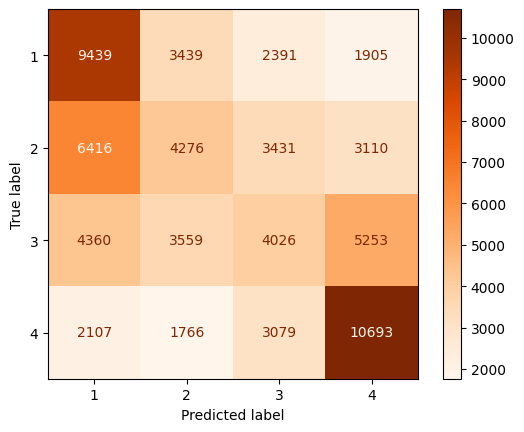

In [45]:
# Visualización de la matriz de confusión

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Oranges)
plt.show()

# Envio a Kaggle

In [52]:

# Preparación para el envío a Kaggle
# Generamos predicciones para los datos de prueba y preparamos el archivo de envío
testPreprocesadoToSend = testPreprocesado.copy()
testPreprocesadoToSend.drop('Unnamed: 0', axis=1, inplace=True)
kagglePredictions = model.predict(testPreprocesadoToSend)

testPreprocesadoToSend['RENDIMIENTO_GLOBAL'] = kagglePredictions
envio = testPreprocesadoToSend[['ID','RENDIMIENTO_GLOBAL']]

# Mapeo inverso de los valores de rendimiento para restaurar las etiquetas originales

mapeo_rendimiento = {
    1: 'bajo',
    2: 'medio-bajo',
    3: 'medio-alto',
    4: 'alto'
}
envio['RENDIMIENTO_GLOBAL'] = envio['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)
# Guardamos el archivo para enviar a Kaggle

envio.to_csv('submission.csv', index=False)
!kaggle competitions submit -c udea-ai4eng-20242 -f submission.csv -m "gradient boosting agrupando por nombre de carrera, region del pais + Bogotá "

<ipython-input-52-7fbd56e117e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  envio['RENDIMIENTO_GLOBAL'] = envio['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)


y
100% 4.00M/4.00M [00:00<00:00, 14.1MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia

# Análisis y reflexión final

Como equipo nos encontramos satisfechos con el resultado obtenido. El porcentaje de precisión si tiraramos un dado de 4 caras sería del 25%, con este modelo estamos ganandole al azar en un 16%.
Con este trabajo también evidenciamos la correlación, y en este caso nos atrevemos a decir también  causalidad, entre la situación socioeconomica y el rendimiento academico de un estudiante en el pais.

Entre las cosas que se nos quedaron en el tintero para mejorar la precisión del modelo esta el crear registros simulados para las variables subrepresentadas y crear un modelo especializado en distinguir entre:
* rendimiento bajo con medio-bajo
* rendimiento alto con medio-alto

de forma que se ejecuta el modelo principal y luego con su respuesta se ejecuta el modelo especializado